# Question 2: DH algorithm (50 points)
**In this question we are going to implement the DH algorithm according to the paper https://icml.cc/Conferences/2008/papers/324.pdf and try to predict protein localization sites in Eukaryotic cells.**

### Wald's Approximation

$$\hat{p}_{v,l} \pm z_{\alpha}\sqrt{\left( \frac{\hat{p}_{v,l}\left( 1-\hat{p}_{v,l} \right)}{n} \right)} $$

where 
- $z_{\alpha}$ is the $\left( 1-\frac{\alpha}{2}\right)$ percentile of the standard normal distribution $N(0,1)$

### Imports and Setup
**Note: To use the Neural Network classifier, you need to install [pytorch](https://pytorch.org/).**

In [1]:
import copy
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage

# for model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



# custom packages
import packages.dh.helper as helper
import packages.dh.dh as dh

# setup
seed = 2021
warnings. filterwarnings("ignore")

## Part 2.0 Data loading and hierarchical clustering
**The DH algorithm is based on hierarchical clustering of the dataset. We will use the DH algorithm on this classification problem: [Protein Localization Prediction](https://archive.ics.uci.edu/ml/datasets/Yeast).**

**The first step is to load the dataset and conduct a hierarchical clustring using the `scipy` package. This part has been implemented, read through the code to make sure you understand what is being done.**

**NOTES:**
- **X_train: data matrix 538x8**
- **Y_train: true labels 538x1**
- **X_test: data matrix 135x8**
- **Y_test: true labels 135x1**

**TIPS:**
- **Check out this [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for details about hierarchical clustering.**
- **If you are unfamiliar with hierarchical clustering using scipy, [this](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ ) is another helpful resource. (We won't use dendrograms here, but he gives a nice explanation of how to interpret the linkage matrix).**
               

### Explore data

In [2]:
df =  pd.read_csv('data/data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
np.unique(df.Label, return_counts=True)

(array(['MIT', 'NUC'], dtype=object), array([244, 429]))

### Load data

In [4]:
# code moved into custom Python module dh.helper
# read data
df = pd.read_csv('data/data.csv')

# filter out samples which are not in filter_class
filter_class = ['MIT', 'NUC']
mask = df.Label == 0
for x in filter_class:
    mask = mask | (df.Label == x)
df = df[mask]

# extract DataFrame features
X = df.iloc[:, :8].to_numpy()

# extract DataFrame labels and encode labels
y = df.Label.astype('category').cat.codes.to_numpy()

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(538, 8)
(538,)
(135, 8)
(135,)


### Construct hierarchy

In [5]:
# code moved into custom Python module dh.helper
# toy example
T = helper.generate_T(X_train[:4])
T

[array([[0, 3],
        [1, 2],
        [4, 5]]),
 array([1., 1., 1., 1., 2., 2., 4.]),
 {6: 0, 0: 4, 3: 4, 1: 5, 2: 5, 4: 6, 5: 6}]

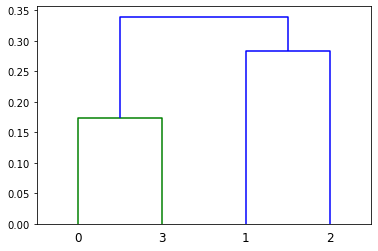

In [6]:
# dendrogram to visualize clustering
Z = linkage(X_train[:4], method='ward')
dn = dendrogram(Z)

# Part 2.0.1 Supervised classification methods.
**We provide several classifiers that can be used. Choose your favourite one. The classifier is going to be used in 2.2, the choose of classifier won't influence your grade.**

**TODO:**
- **Choose and initialize a classifier**

**Note: To use the Neural Network classifier, you need to install [pytorch](https://pytorch.org/).**

In [7]:
def get_classifier(choice, X=None, y=None, seed=None):
    """
    Generates a classifier of the specified choice.

    :param choice: String representing the desired classifier
    :param X: Used to define Neural Network
    :param y: Used to define Neural Network
    :param seed: Used to define Random Forest, Gradient Boosting, Neural Network
    :return: initialized model
    """
    model = None

    if choice == 'Logistic Regression':
        lr = LogisticRegression()
        model = lr

    elif choice == 'Random Forest':
        N_estimator_rf = 20
        MAX_depth_rf = 6
        rf = RandomForestClassifier(n_estimators=N_estimator_rf,
                                    max_depth=MAX_depth_rf,
                                    random_state=seed)
        model = rf

    elif choice == 'Gradient Boosting Decision Tree':
        N_estimator_gbdt = 20
        gbdt_max_depth = 6
        gbdt = GradientBoostingClassifier(n_estimators=N_estimator_gbdt,
                                          learning_rate=0.1,
                                          max_depth=gbdt_max_depth,
                                          random_state=seed)
        model = gbdt

    elif choice == 'Neural Net':
        
        import torch
        from torch.utils.data import DataLoader, TensorDataset
        from torch import optim

        # 3-layer fully connected neural network
        torch.manual_seed(seed)

        class NNClassifier(object):
            def __init__(self,
                         feature_n,
                         class_n,
                         hidden_n=30,
                         learning_rate=4e-3,
                         weight_decay=1e-5):
                self.model = torch.nn.Sequential(torch.nn.Linear(feature_n, hidden_n),
                                                 torch.nn.SiLU(),
                                                 torch.nn.Linear(hidden_n, hidden_n),
                                                 torch.nn.SiLU(),
                                                 torch.nn.Linear(hidden_n, class_n))
                self.lr = learning_rate
                self.wd = weight_decay

            def fit(self, X_train, y_train, epoches=300, batch_size=50):
                X_t = torch.from_numpy(X_train.astype(np.float32))
                y_t = torch.from_numpy(y_train.astype(np.int64))
                dataset = TensorDataset(X_t, y_t)
                loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
                loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
                optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
                loss_record = 0.0
                report_epoch = 50
                for epoch_i in range(epoches):
                    for batch in loader:
                        x_batch, y_batch = batch
                        y_pred = self.model(x_batch)
                        loss = loss_fn(y_pred, y_batch)
                        self.model.zero_grad()
                        loss.backward()
                        optimizer.step()
                        loss_record += loss.item()
                    if epoch_i % report_epoch == report_epoch - 1:
                        # print("[%d|%d] epoch loss:%.2f" % (epoch_i + 1, epoches, loss_record / report_epoch))
                        loss_record = 0.0
                    if epoch_i >= epoches:
                        break
                return self

            def score(self, X_test, y_test):
                X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
                y_pred_test = self.model(X_test_tensor)
                y_output = torch.argmax(y_pred_test, axis=1).numpy()
                return (y_output == y_test).mean()

        nn = NNClassifier(feature_n=X.shape[1], class_n=len(np.unique(y)))
        model = nn

    return model


### Comparison of options

In [8]:
# options
lr = get_classifier('Logistic Regression').fit(X_train,y_train)
rf = get_classifier('Random Forest', seed).fit(X_train,y_train)
gbdt = get_classifier('Gradient Boosting Decision Tree', seed).fit(X_train,y_train)
nn = get_classifier('Neural Net', X_train,y_train, seed).fit(X_train,y_train)


# Accuracy of 4 classifiers.
print('Accuracy of logistic regression: \t\t{:.3f}'.format(lr.score(X_test,y_test)))
print('Accuracy of random forest: \t\t\t{:.3f}'.format(rf.score(X_test,y_test)))
print('Accuracy of Gradient Boosting Decision Tree: \t{:.3f}'.format(gbdt.score(X_test,y_test)))
print('Accuracy of Neural Network: \t\t\t{:.3f}'.format(nn.score(X_test,y_test)))


Accuracy of logistic regression: 		0.874
Accuracy of random forest: 			0.874
Accuracy of Gradient Boosting Decision Tree: 	0.867
Accuracy of Neural Network: 			0.889


### Choose and initialize your classifier

In [9]:
classifier = get_classifier('Logistic Regression')

## Part 2.1 Implement DH algorithm (Hierarchical Sampling for Active Learning). (30 points)

**TODO:**
- **Please complete the functions to implement the DH algorithm and run the active learning algorithm on the training dataset.**
- **The utils functions has been implemented and attached in the homework folder, including `update_empirical.py`, `best_pruning_and_labeling.py`, `assign_labels.py`, and `get_leaves.py`. Please read them and finish the following functions to implement the DH algorithm.**

In [10]:
# moved all helper functions into module dh.helper
# implemented in custom Python package dh

## Part 2.2 Run the sample code (10 points)
**TODO:**
- **Run the following sample code and compare the two figures.**
- **Answer the following questions about the results:**
    - **How fast does each model converge?**
    - **How does error change as we apply more iterations?**
    - **Which selection strategy is more accurate?**

In [11]:
plt.rcParams["figure.figsize"] = (15,10) # control size of plot

In [12]:
# ?? why make a copy of classifier when only one can be used in the function?
def call_DH(part, clf, budget, X_train, y_train, X_test, y_test, choice):
    """
    Main function to run all your code once complete.  After you complete
   select_case_1() and select_case_2(), this will run the DH algorithm for each
   dataset and generate the plots you will submit within your write-up.

    :param part: which part of the homework to run
    :param clf: The classifier to be trained on the dataset.
    :param budget: The number of times that one can query a label from the oracle.
    :return:
    """
    num_trials = 5
    batch_size = 10
#     clf2 = copy.deepcopy(clf)  # unnecessary
    axs = plt.subplot()

    # initialize components
    T = helper.generate_T(X_train)
    loss = np.zeros(budget)  # loss for each iteration
    
    # choose action depending on part
    if part.lower() == "b":

        print("Running part B " + choice + "...")

        # run trials
        for i in range(num_trials):
            print("Currently on iteration {}...".format(i))
            L, error = dh.select_case_1(X_train, y_train, T, budget, batch_size)
            loss += error
        loss /= num_trials


        # train the classifier clf on the predicted label.
        clf.fit(X_train, L[:len(X_train)])

        # plot
        score = clf.score(X_test, y_test)
        print('Accuracy of classifier trained on proportional sampling dataset: \t{:.3f}'.format(score))
        axs.plot(np.arange(budget), loss, label="Proportional sampling " + choice)

    elif part.lower() == "c":

        print("Running part C " + choice + "...")

        # run trials
        for i in range(num_trials):
            print("Currently on iteration {}...".format(i))
            L, error = dh.select_case_2(X_train, y_train, T, budget, batch_size)
            loss += error
        loss /= num_trials

        # train the classifier clf on the predicted label
        clf.fit(X_train, L[:len(X_train)])

        score = clf.score(X_test, y_test)
        print('Accuracy of classifier trained on confidence adjusted sampling dataset: \t{:.3f}'.format(score))
        axs.plot(np.arange(budget), loss, label="Confidence adjusted sampling " + choice)

    else:
        print("Incorrect part argument. Either 'b', 'c', 'd', or 'e' expected:", part)

    
    axs.set_ylim([0, 0.5])
    axs.set_xlabel("Number of query samples")
    axs.set_ylabel("Error rate")
    plt.title('Number of Queries vs Error Rate')
    plt.grid()
    plt.legend()
    plt.savefig("img/q2_2_" + part.lower() + "_budget" + str(budget) + "_" + str(batch_size) + "_" + choice + ".png")
    print()
    return loss

    

In [ ]:
%%time
# 9 min for all one method with 200 budget

# choices= ['Logistic Regression','Random Forest', 'Gradient Boosting Decision Tree','Neural Net']
choices = ['Random Forest']
losses = []

# run active learning
BUDGET = 200
for part in "bc":
    for choice in choices:
        classifier = get_classifier(choice, X_train,y_train, seed)
        loss = call_DH(part,classifier,BUDGET,X_train, y_train, X_test, y_test, choice)
        losses.append(loss)


Running part B Random Forest...
Currently on iteration 0...
Currently on iteration 1...
Currently on iteration 2...
Currently on iteration 3...
Currently on iteration 4...
Accuracy of classifier trained on proportional sampling dataset: 	0.874

Running part C Random Forest...
Currently on iteration 0...
Currently on iteration 1...
Currently on iteration 2...


### Answers to questions about model performance

#### How fast does each model converge?
The proportional (random) sampling model and confidence adjusted (active learning) sampling converge at about the same rate. Within only a few queries, both models achieve an error rate 20-30%. Afterward, they improve (approximately) linearly with the number of queries.

#### How does error change as we apply more iterations?
For both models, error rate decreases (approximately) linearly within the first 200 queries. The error rate reduces at a faster rate the more queries are performed for the active learning model.

#### Which selection strategy is more accurate?
For the first 100 queries, both models have similar accuracy. After 100 queries, the active learning model decreases its error rate more quickly. This indicates that the active learning algorithm is more accurate overall.

### Comparison with Offline Learner
For fun. Offline learner receives randomly selected points.

In [ ]:
%%time


random_error = []

X_train_rand = copy.deepcopy(X_train)
y_train_rand = copy.deepcopy(y_train)

for t in range(200):
    
    # select sample from pool randomly
    idx = np.random.choice(X_train_rand.shape[0], 1, replace=False)
    
    # add instance to training set
    if t == 0:
        X_rand = X_train_rand[idx,:]
        Y_rand = y_train_rand[idx]
    else:
        new_x = X_train_rand[idx,:]
        X_rand = np.append(X_rand,new_x,axis=0)
        new_y = y_train_rand[idx]
        Y_rand = np.append(Y_rand,new_y)


    if 0 in Y_rand and 1 in Y_rand:

        # train model and score it
        clf = get_classifier('Random Forest')
        clf.fit(X_rand, Y_rand)
        score = 1-clf.score(X_test, y_test)
        random_error.append(score)


In [ ]:
# append values to front to make up for lack of training at the start
diff = BUDGET - len(random_error)
if diff > 0:
    random_error = [None for i in range(diff)] + random_error

# plot all results together
axs = plt.subplot()
for i, loss in enumerate(losses):
    axs.plot(np.arange(len(loss)), loss, label="Active learning " + str(i))

axs.plot(np.arange(len(random_error)), np.array(random_error), label="Offline learning RF")
plt.title('Number of Queries vs Error Rate')
plt.legend()
plt.grid()
plt.savefig("img/q2_2_offline.png")
    

## Part 2.3 Questions (10 points):
**Answer the following questions.**
### What is an "admissible pair" according to the paper (5 points)?

According to the paper, an admissible pair $(v,l)$ is an admissible label $l$ for given node $v$. A label $l$ is admissible if assigning that label to a given node results in at most $\beta$ times as much error as assigning any other label to that node. 

Maintaining a set of admissible pairs for all nodes for a given time step $t$ prevents DH from descending too far into the tree when the statistics it is using to make decisions are sparse.


### Please explain the sampling bias that is dealt with in the DH algorithm and why it would be a problem if we just query the unlabeled point which is closest to the decision boundary (5 points)?


#### Part 1 - Explain how sampling bias is handled
Sampling bias is introduced when active learning algorithms focus queries in targeted regions of the sample space rather than drawing i.i.d. from the sampling distribution. This results in the training set having a different distribution than the test set, and bias can lead to poor generalization.

With DH, sampling bias is handled in two parts, following the two parts of selecting nodes. 

First, select a subtree with a probability weight proportional to their size within the larger tree. For the test distribution, the proportion of i.i.d. samples that come from a particular subtree should follow the proportion of the subtree to the tree (i.e. a small region of the sample space is likely to be sampled less than a large region of the sample space). Setting probability weights using this proportion corrects for sampling bias in the training distribution. 

Each subtree has a size greater than zero, so there is always a chance of selecting nodes from that subtree in the current pruning. 

Once a subtree has been chosen, select points within that subtree uniformly at random. Each node in the subtree has the same chance of being chosen.



#### Part 2 - Explain why querying the boundary would be a problem
One strategy for active learning query selection is to select unlabeled points closest to the decision boundary (current estimate). If the sampling space is piecewise, information is concentrated in the boundary between pieces. By focusing a limited query budget on the boundary, the algorithm can efficiently learn this information and produce an accurate model. 

The problem with focusing on the currently known decision boundary is that we might never discover regions of difference in other parts of the sample space. (A part of the sample space believed to be uniform may turn out to have distinct classes within it.) The consequence is that our model would not generalize as well as it possibly could, had it found this region of difference, so we are left with a suboptimal model.